In [11]:
import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pickle
import HALS.HALS as hals

plt.style.use('ggplot')
myColor  = ("#E3072A","#0A8974","#5FAECC","#E49C23","#E27520") # Darjeeling Color map

We load the data file that we generated with "03_add_atm_tides.ipynb"

In [5]:
# Load results

path = 'Results/pkl_files/'

with open(path + 'interpolated_data_baro.pkl', 'rb') as f:
    data = pickle.load(f)
data.keys()

dict_keys(['B1', 'B2'])

Specify the target constituents for the HALS analysis

In [6]:
# Earth tide frequencies
et_fqs = {'Q1': 0.893244, 'O1': 0.929536, 'M1': 0.966446, 'P1': 0.997262, 'S1': 1.0, 'K1': 1.002738, 'N2': 1.895982, 'M2': 1.932274, 'S2': 2.0, 'K2': 2.005476}
# Atmospheric tide frquencies
at_fqs = {'P1': 0.997262, 'S1': 1.0, 'K1': 1.002738, 'S2': 2.0, 'K2': 2.005476}


Create datetime column and convert it to a numeric


In [7]:
for key in data:

    # streamline the column format
    data[key].index = pd.to_datetime(data[key].index, dayfirst=True)

    # create a numeric value column
    dnum_col = pd.to_numeric(data[key].index)
    dnum_col = (dnum_col-dnum_col[0])
    dnum_col = dnum_col/ 10**9 # from ns to seconds
    dnum_col = dnum_col/(60*60*24) # to days

    data[key].insert(0,"dnum",dnum_col)

data[key].dnum

date
2016-09-01 13:00:00      0.000000
2016-09-01 14:00:00      0.041667
2016-09-01 15:00:00      0.083333
2016-09-01 16:00:00      0.125000
2016-09-01 17:00:00      0.166667
                          ...    
2017-09-25 08:00:00    388.791667
2017-09-25 09:00:00    388.833333
2017-09-25 10:00:00    388.875000
2017-09-25 11:00:00    388.916667
2017-09-25 12:00:00    388.958333
Name: dnum, Length: 9336, dtype: float64

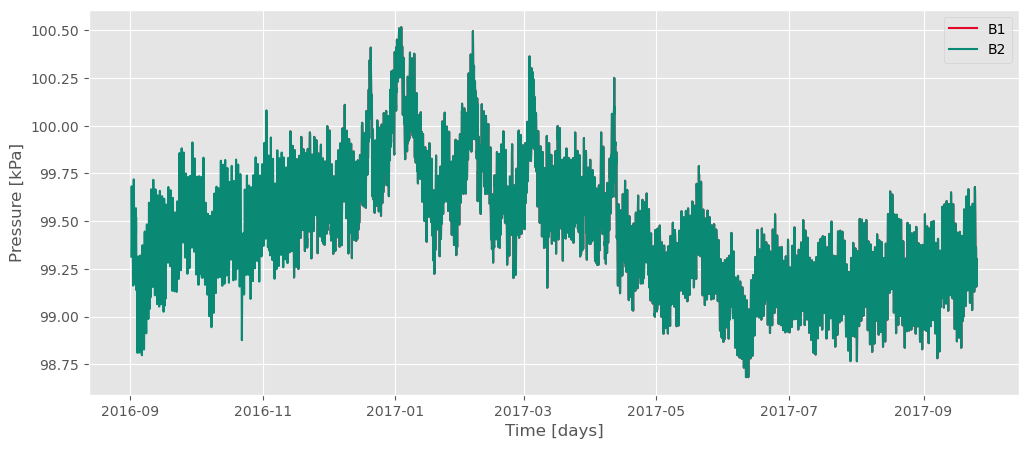

In [8]:
fig, ax = plt.subplots(nrows= 1,figsize=(12.0,5.0), sharex = True) # ,sharey=True

for i, key in enumerate(data):
    str_ = data[key]['pressure[kPa]']
    ax.plot(data[key].index, str_, label = key,color=myColor[i])

ax.set_ylabel("Pressure [kPa]")
ax.set_xlabel("Time [days]")
ax.legend(loc="upper right")

Detrend the data with the overlapping window function

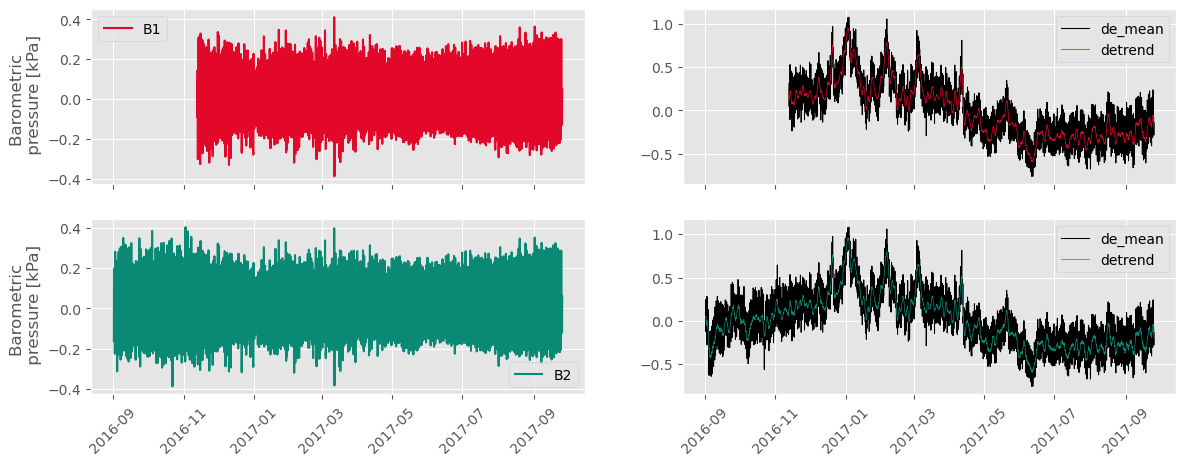

In [13]:
length = 2.0 # length of the detrend window
stopper = 2 # minimum number of samples in window
n_ovrlp = 5 # number of window overlaps

fig, ax = plt.subplots(nrows= len(data.keys()),ncols=2,figsize=(14.0,5.0), sharex = True) # ,sharey=True
dic_detr = {}

for j, key in enumerate(data):
    
    # create a new dataframe for the detrended data
    df_detr = pd.DataFrame(data[key].dnum, columns = ["dnum"])
    gw_col = np.array(['pressure[kPa]'])
    
    for name,i in zip(gw_col,range(len(gw_col))):
        gw = data[key][name]
        # detrending of the data
        df_detr[name] = hals.lin_window_ovrlp(data[key].dnum, gw.values,length=length,stopper=stopper,n_ovrlp=n_ovrlp)
        ax[j,0].plot(data[key].index,df_detr[name], label = key, color=myColor[j])
        ax[j,0].legend()
        ax[j,0].set_ylabel("Barometric \n pressure [kPa]")
        
        de_mean = gw.values - np.nanmean(gw.values)
        
        ax[j,1].plot(data[key].index, de_mean, label='de_mean', lw=0.75,color="black")
        ax[j,1].plot(data[key].index, de_mean - df_detr[name], label='detrend', lw=0.5, color=myColor[j])
        ax[j,1].legend(loc="upper right")       
    
    dic_detr[key] = df_detr

ax[j,0].tick_params(axis='x', labelrotation=45)
ax[j,1].tick_params(axis='x', labelrotation=45)   

Save results to plot

In [14]:
# Save data

path = '/home/jose/MEGA/PhD/Paper_3/data_cleaned/HALS/'

with open(path + 'baro_detr.pkl', 'wb') as f:
    pickle.dump(dic_detr, f)

Apply HALS to extract the tidal constituent properties from the detrended data


In [21]:
# merge earth and atmospheric tide dictionaries
freqs = {**et_fqs, **at_fqs}
df_A = pd.DataFrame.from_dict(freqs,orient="index",columns=["freqs"])
df_phi = pd.DataFrame.from_dict(freqs,orient="index",columns=["freqs"])
df_complex = pd.DataFrame.from_dict(freqs,orient="index",columns=["freqs"])

for j, key in enumerate(data):
    
    # loop over the groundwater head measurement data sets
    #HALS function
    output = hals.hals_lsq(dic_detr[key].dnum.values, dic_detr[key]['pressure[kPa]'], list(freqs.values()))
    df_A[key] = output[0] #Amplitudes
    df_phi[key] = output[1] #Phases
    df_complex[key] = output[5] #Complex numbers
    
df_phi    

Conditioning number:  1.6890435014633067
Conditioning number:  1.4595125987027826


,freqs,B1,B2
Q1,0.893244,-1.181430,1.738963
O1,0.929536,0.640427,-1.596524
M1,0.966446,2.381003,3.030972
P1,0.997262,0.716903,0.356797
S1,1.000000,1.863103,0.236049
K1,1.002738,2.982889,-0.117777
N2,1.895982,1.931337,1.894131
M2,1.932274,2.358324,-1.529088
S2,2.000000,2.845718,-0.336724
K2,2.005476,-1.701867,-1.292799


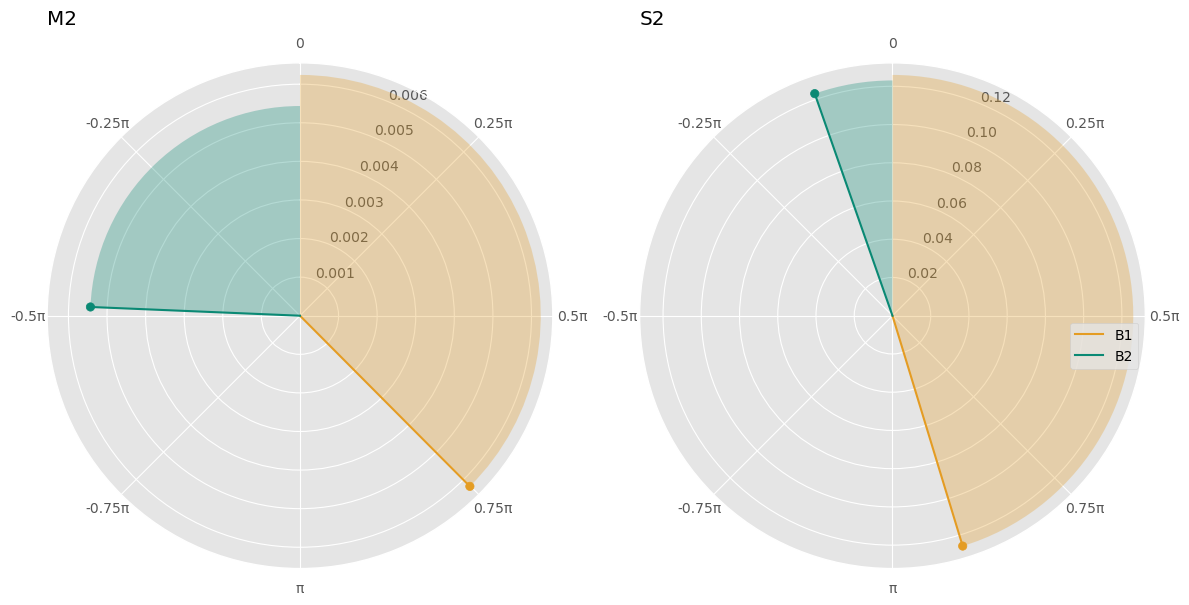

In [22]:
target = ["M2","S2"]
myColor  = ("#E49C23","#0A8974")

df_A = df_A.loc[target,data.keys()]
df_phi = df_phi.loc[target,data.keys()]

def radian_function(x, pos =None):
    # the function formatter sends
    rad_x = x/np.pi
    if rad_x == 0:
        return "0"
    if rad_x == 1:
        return "π"
    elif rad_x > 1:
        rad_x -= 2
        return "{}π".format(str(rad_x if rad_x % 1 else int(rad_x)))
    return "{}π".format(str(rad_x if rad_x % 1 else int(rad_x)))

fig = plt.figure(figsize=(12,12))

col = 1
for t in target:
    theta = df_phi.loc[t].values # angle
    amp = df_A.loc[t].values # amplitude
    
    amp = amp # convert to mm
    width = -theta # span
    
    ax = fig.add_subplot(1,2,col, polar=True)
    ax.bar(theta, amp, width=width, bottom=0.0, color=myColor, alpha=0.3,align="edge")
    ax.scatter(theta,amp, marker="o",color=myColor) #color=myColor[c]
        
        
    for i,j,c,l in zip(amp,theta,myColor,data.keys()):
        ax.plot([j]*2,[0,i],color=c,label=l)
        #print([j]*2,[0,i])
       # count = count +1
        

    ax.set_theta_zero_location("N") # orient north
    ax.set_theta_direction(-1) # reverse direction
    col+=1
    ax.set_title(t, va='bottom',loc="left")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(radian_function))
    if t == target[-1]:
        ax.legend(bbox_to_anchor=(1.0, 0.5))
    
plt.tight_layout() 

In [23]:
results = {}

results['amp'] = df_A
results['phase'] = df_phi
results['complex'] = df_complex

# Save data

path = 'Results/pkl_files/'

with open(path + 'baro.pkl', 'wb') as f:
    pickle.dump(results, f)